# PClassifier - A NLP approach for classifying grocery products
This notebook implements a basic model for classifying grocery products for the GroceryListPredictor project, written by David Hahnemann, Simon Skade und Luan Ademi for the german national artifical intelligence contest <a href="https://bw-ki.de/app/entry-page">BwKI</a>

In [37]:
# import the libraries needed for the RNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# some helper classes (see util.py)
from util import randomChoice, lineToTensor, readFile

# for debugging
from IPython.core.debugger import set_trace

# import matplotlib for plotting 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# other libraries required by this notebook
import string
import time
import math
import random
import glob
import os

# the number of hidden neurons of the RNN
n_hidden = 128

# the learning rate
learning_rate = 0.0005

# a list containing all ascii caracters and some german exclusive ones
all_letters = string.ascii_letters + " .,;'" + "äÄüÜöÖß"
n_letters = len(all_letters)

# define the device for the training (Due to a small number of neurons, training on the cpu actually is faster)
device = torch.device("cpu")

## The RNN model
We initialize a simple self feeding network, which consists of two linear layers. The input and the hidden state are passed through **i2h** and **i2o** and the network returns a new hidden state and a normalized probability distribution consisting of a probability for every category defined.

In [38]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # softmax_i(x) = log( exp(x_i) / sum(x_z) )  

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Retrieve the data from the word lists
We read in all the text files from the directory and create the classes and their corresponding elements

In [39]:
category_lines = {}
categories = []

In [40]:
for filename in glob.glob('../Produktlisten/*.txt'):
    # create the catergories from the filenames
    category = os.path.splitext(os.path.basename(filename))[0] 
    categories.append(category)
    # assign the lines from the file to that category
    lines = readFile(filename) 
    category_lines[category] = lines

In [41]:
n_categories = len(categories)

In [49]:
rnn = RNN(n_letters, n_hidden, n_categories).to(device) # out model
criterion = nn.NLLLoss() # the negative log likelihood loss
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

In [50]:
# returns the prediction of the network by passing every letterTensor through the network
def evaluate(line_tensor):
    hidden = rnn.initHidden() # initialize a hidden tensor for the first feed
    
    # pass every letter tensor through the network
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [51]:
rnn.load_state_dict(torch.load("state_dicts/model.pt")) # loads a prtrained model

RuntimeError: Error(s) in loading state_dict for RNN:
	size mismatch for i2o.weight: copying a param with shape torch.Size([12, 192]) from checkpoint, the shape in current model is torch.Size([13, 192]).
	size mismatch for i2o.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([13]).

In [52]:
# returns a random training example
def randomTrainingExample():
    category = randomChoice(categories)
    line = randomChoice(category_lines[category])

    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)

    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

## Train the network

In [53]:
# performs a training step with the given line and category tensor
def train(category_tensor, line_tensor):
    
    hidden = rnn.initHidden() # initialize a hidden tensor for the first feed

    optimizer.zero_grad() # reset the current gradients 
    
    # pass every letter tensor through the network
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    # define our loss criterion
    loss = criterion(output, category_tensor)
    loss.backward()

   
    # Add parameters gradients to their values, multiplied by learning rate (Gradient Descent)
    optimizer.step()

    return output, loss.item()

In [54]:
# retieves the category of an output by the network
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return categories[category_i], category_i

## Main Loop

5000 3% (0m 4s) 0.1174 GEFLÜGELFLEISCH / fleisch ✓
10000 6% (0m 8s) 1.5375 KNOBLAUCH / gewuerze ✗ (gemuese)
Got NaN at iteration 13870
> <ipython-input-55-1961f7bfe7b2>(26)<module>()
     24         print("Got NaN at iteration " + str(iter))
     25         set_trace()
---> 26         break
     27 
     28     # Print iter number, loss, name and guess

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


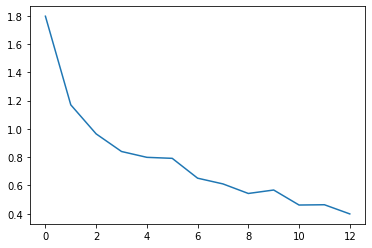

ipdb>  exit()


In [55]:
n_iters = 150000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # the logSoftmax function sometimes returns nan, hence the loss is nan. Still haven't found the cause :/
    if np.isnan(loss):
        print("Got NaN at iteration " + str(iter))
        set_trace()
        break

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# plot the graph of the losses returned during training
plt.figure()
plt.plot(all_losses)

## Evaluate the result

In [33]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, categories[category_index]))
            predictions.append([value, categories[category_index]])

In [36]:
predict("Ventilator".upper())


> VENTILATOR
(-0.21) obst
(-2.01) gewuerze
(-2.90) gemuese


In [25]:
torch.save(rnn.state_dict(), "state_dicts/model.pt") # save the trained model